In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

In [4]:
os.getcwd()

'C:\\Users\\louis.anderson'

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [6]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [7]:
adata2 = sc.read_h5ad("meyernikolic.h5ad")

In [8]:
adata2.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [9]:
adata2

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

normalizing counts per cell
    finished (0:00:29)


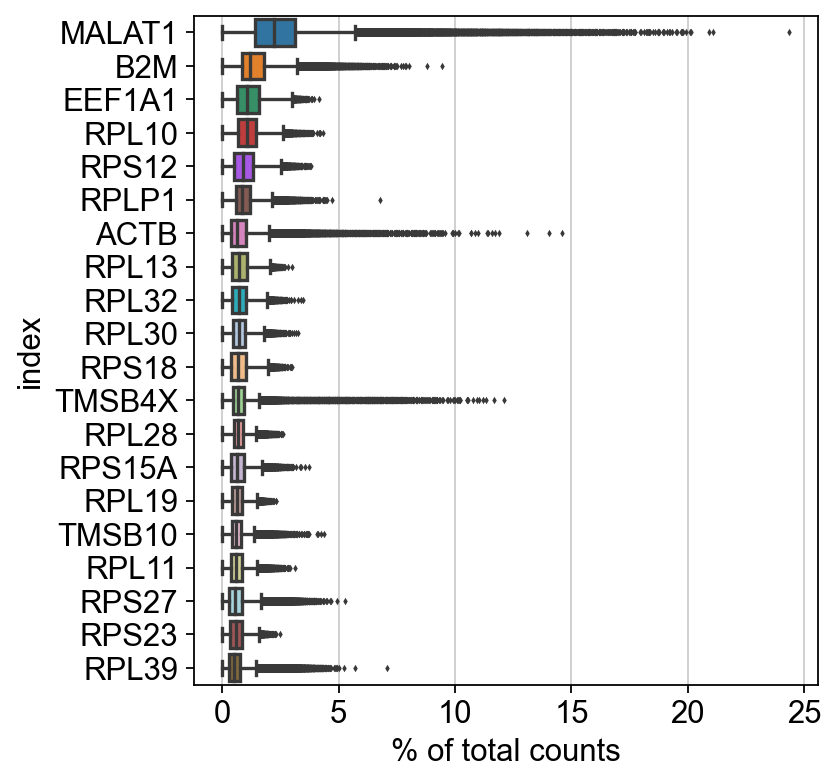

In [10]:
sc.pl.highest_expr_genes(adata2, n_top=20, )

In [11]:
sc.pp.filter_cells(adata2, min_genes=100)
sc.pp.filter_genes(adata2, min_cells=10)

filtered out 11348 genes that are detected in less than 10 cells


In [12]:
adata2.var['mt'] = adata2.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

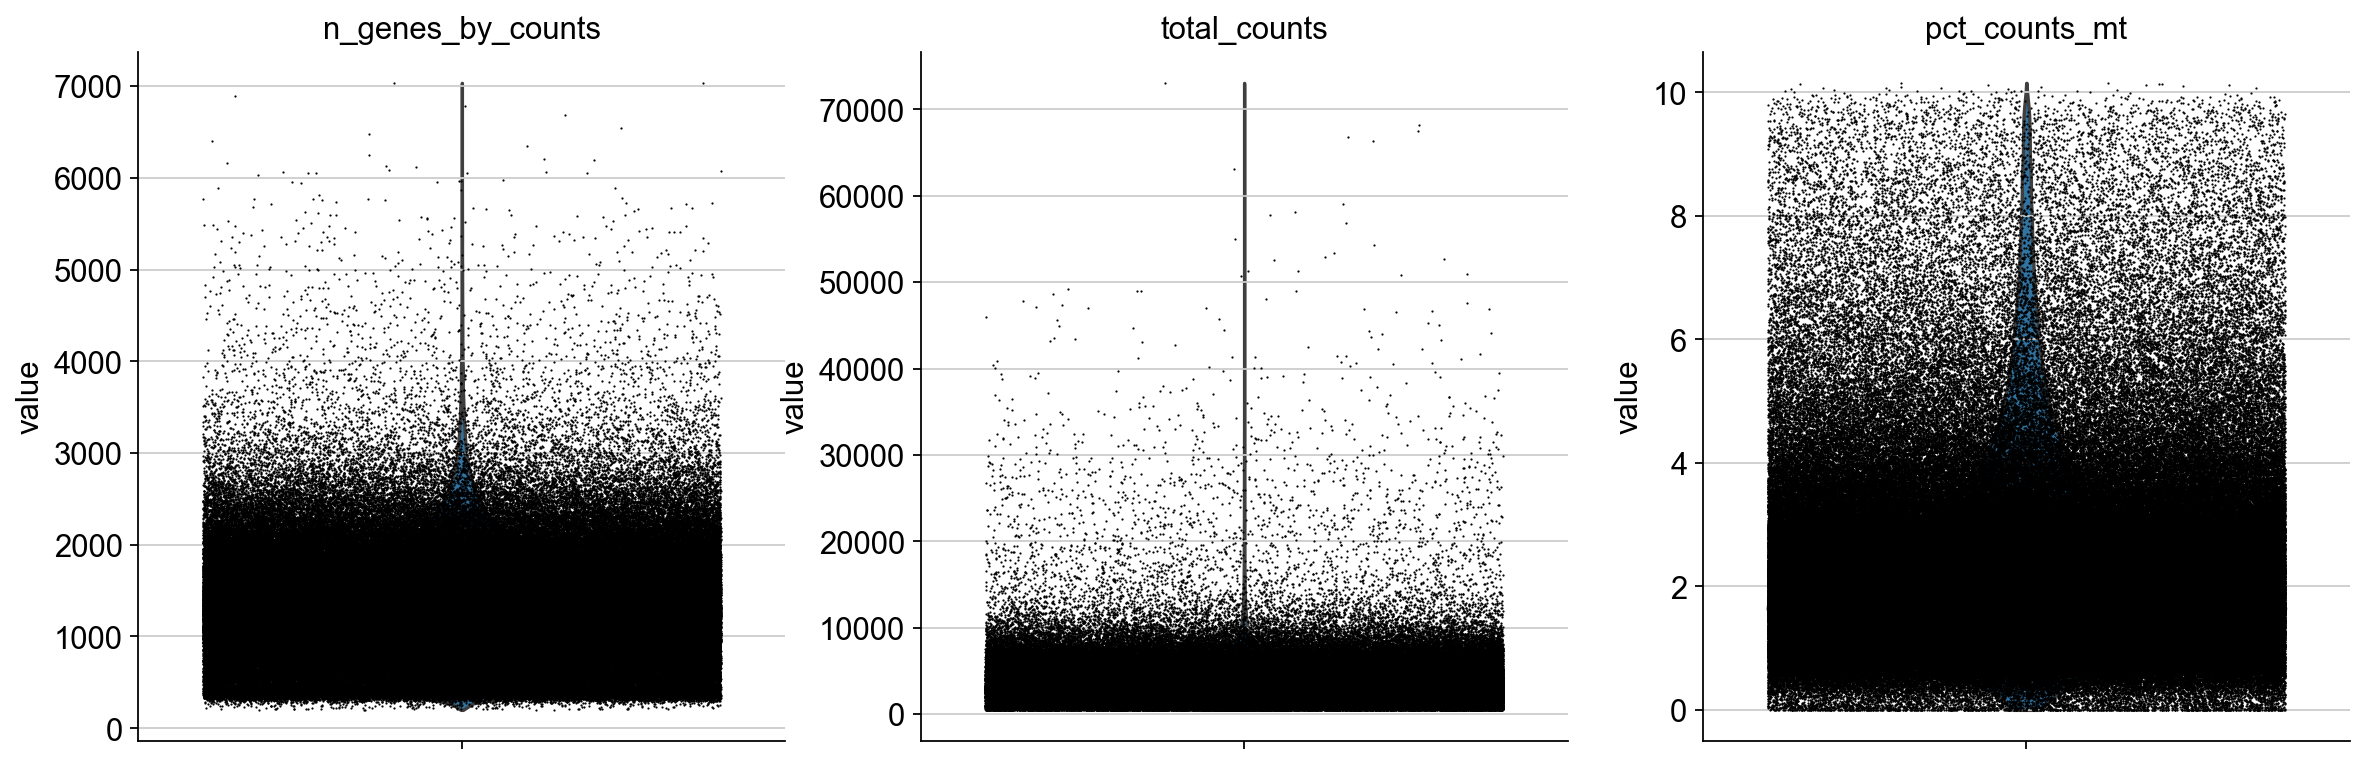

In [13]:
sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

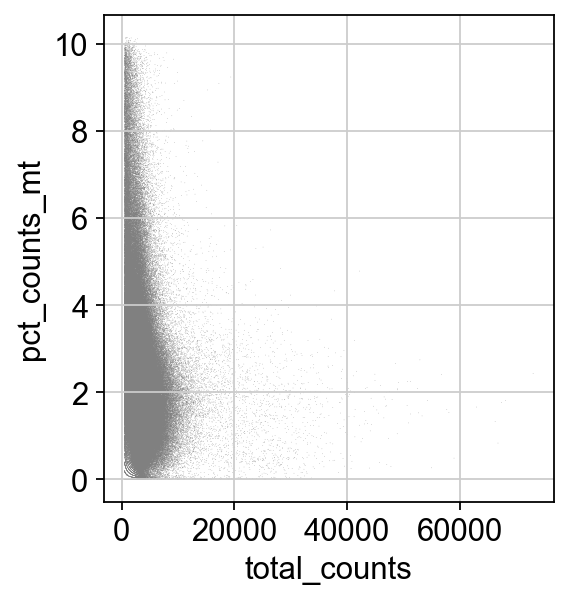

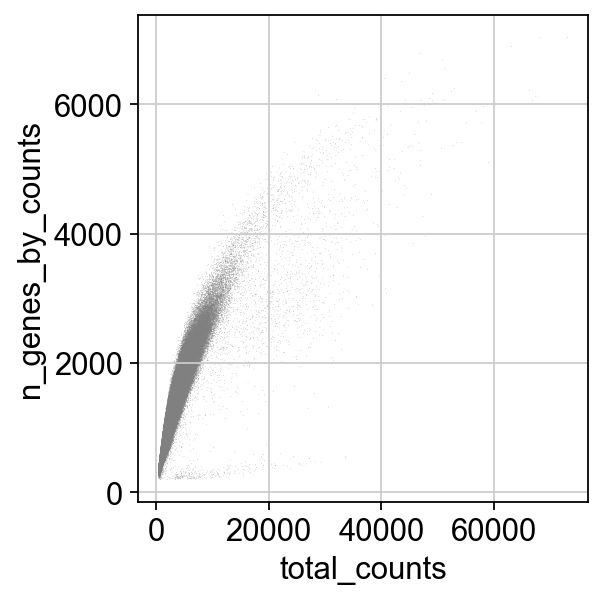

In [14]:
sc.pl.scatter(adata2, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata2, x='total_counts', y='n_genes_by_counts')

In [15]:
adata2 = adata2[adata2.obs.n_genes_by_counts < 2500, :]
adata2 = adata2[adata2.obs.pct_counts_mt < 5, :]

In [16]:
sc.pp.normalize_total(adata2, target_sum=1e4)

C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:08)


In [17]:
sc.pp.log1p(adata2)


In [18]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


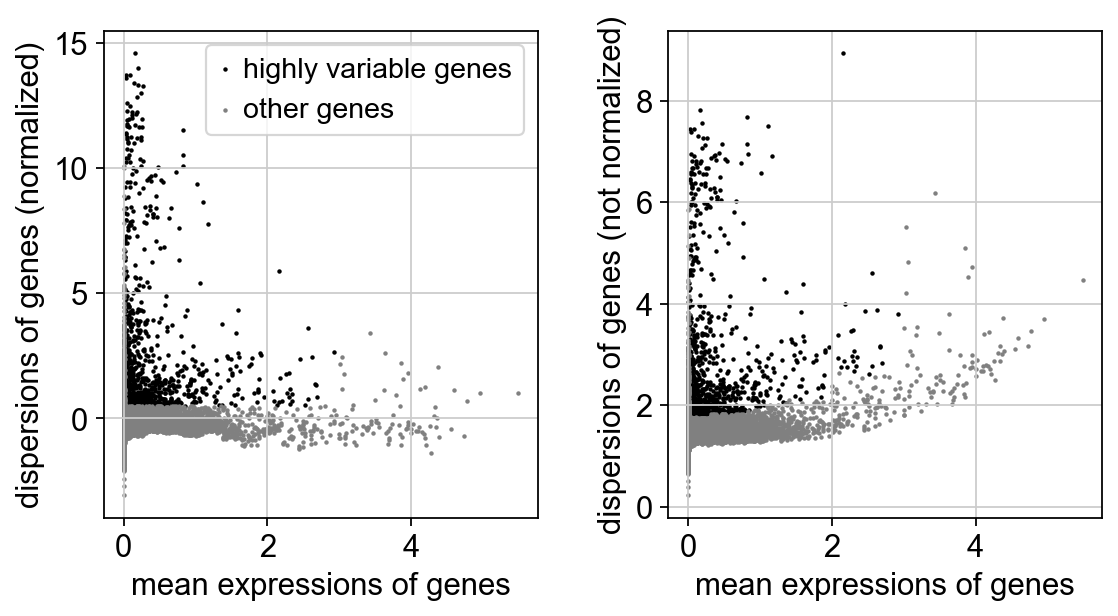

In [19]:
sc.pl.highly_variable_genes(adata2)

In [20]:
adata2.raw = adata2

In [21]:
adata2 = adata2[:, adata2.var.highly_variable]

In [22]:
sc.pp.regress_out(adata2, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:06:47)


In [23]:
sc.pp.scale(adata2, max_value=10)

In [24]:
sc.tl.pca(adata2, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:57)


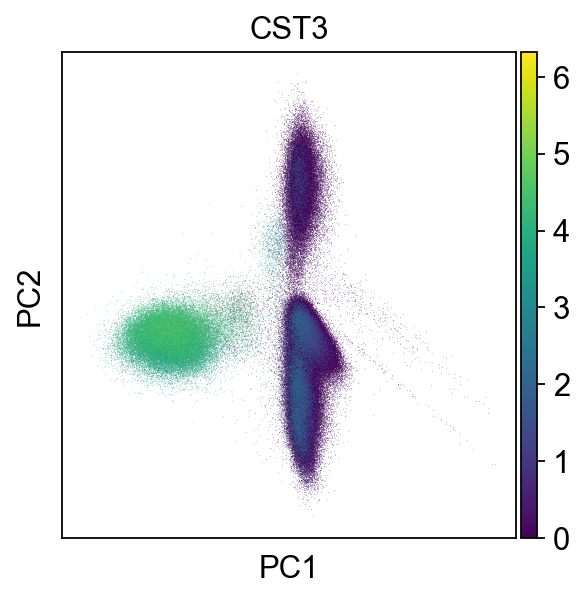

In [25]:
sc.pl.pca(adata2, color='CST3')


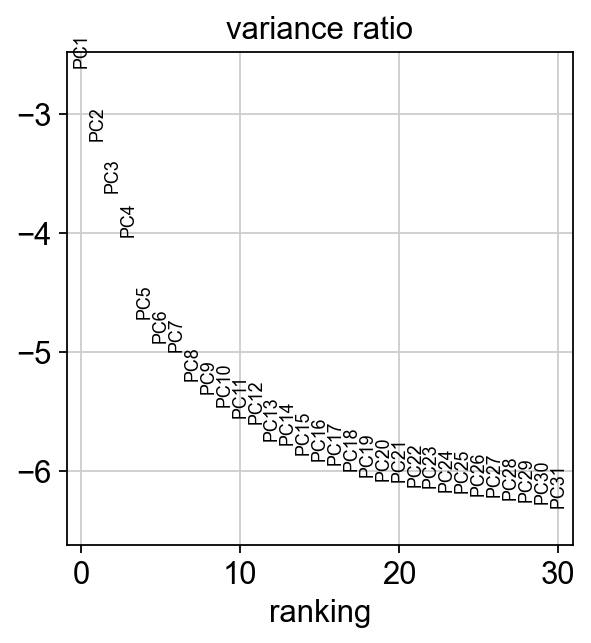

In [26]:
sc.pl.pca_variance_ratio(adata2, log=True)

In [30]:
results_file

'write/pbmc3k.h5ad'

In [31]:
adata2.write(results_file)

In [32]:
adata2

AnnData object with n_obs × n_vars = 384606 × 970
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [33]:
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:50)


In [36]:
sc.tl.umap(adata2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:13:29)


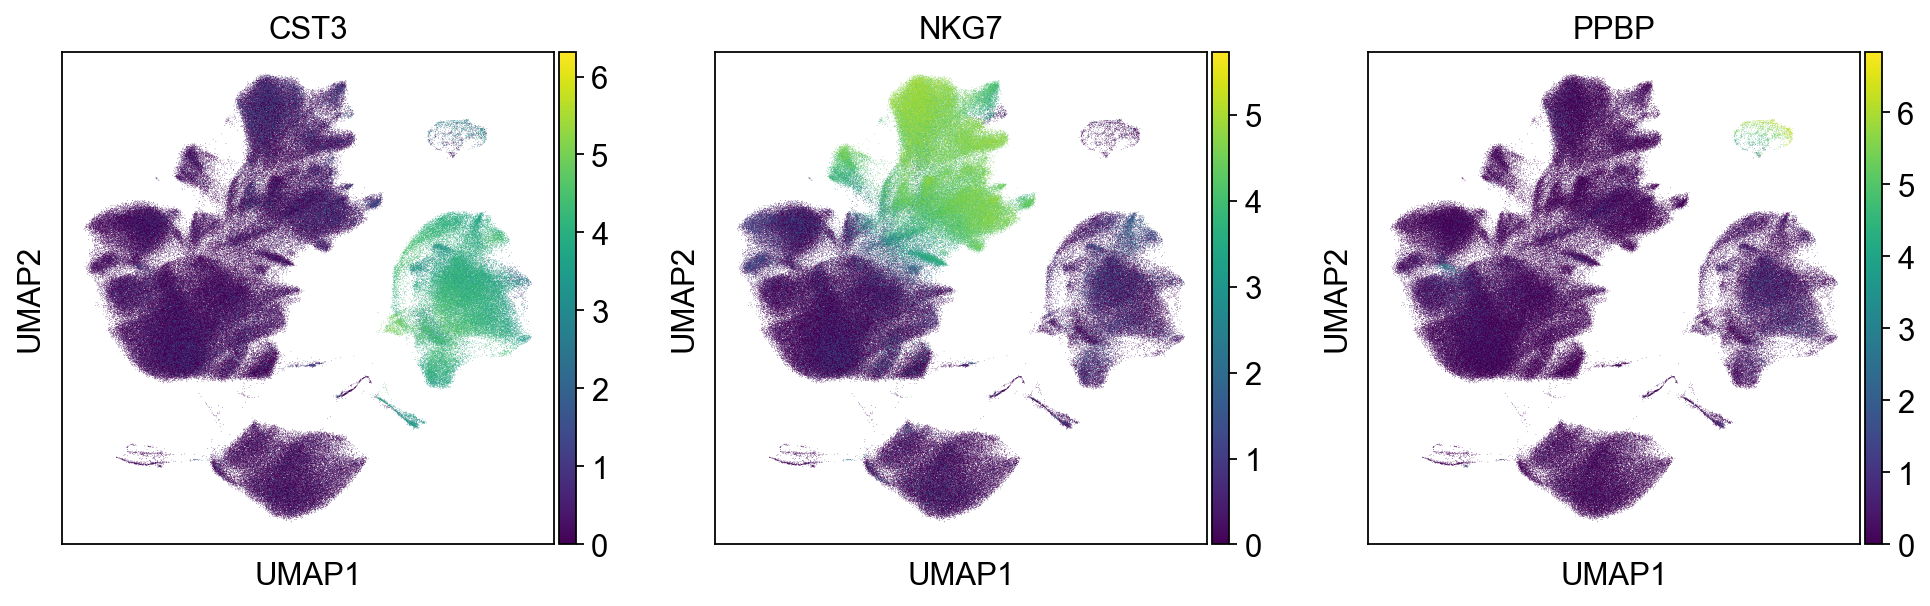

In [37]:
sc.pl.umap(adata2, color=['CST3', 'NKG7', 'PPBP'])

KeyError: 'Could not find key NKG7 in .var_names or .obs.columns.'

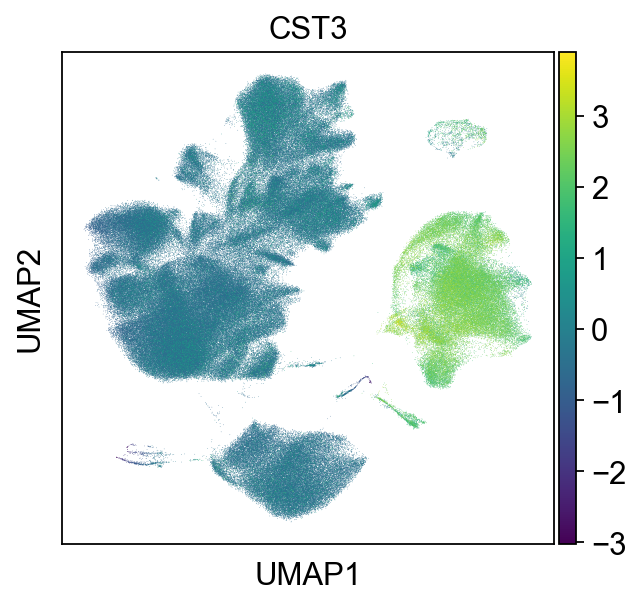

In [38]:
sc.pl.umap(adata2, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [39]:
sc.tl.leiden(adata2)


running Leiden clustering
    finished: found 31 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:20:28)


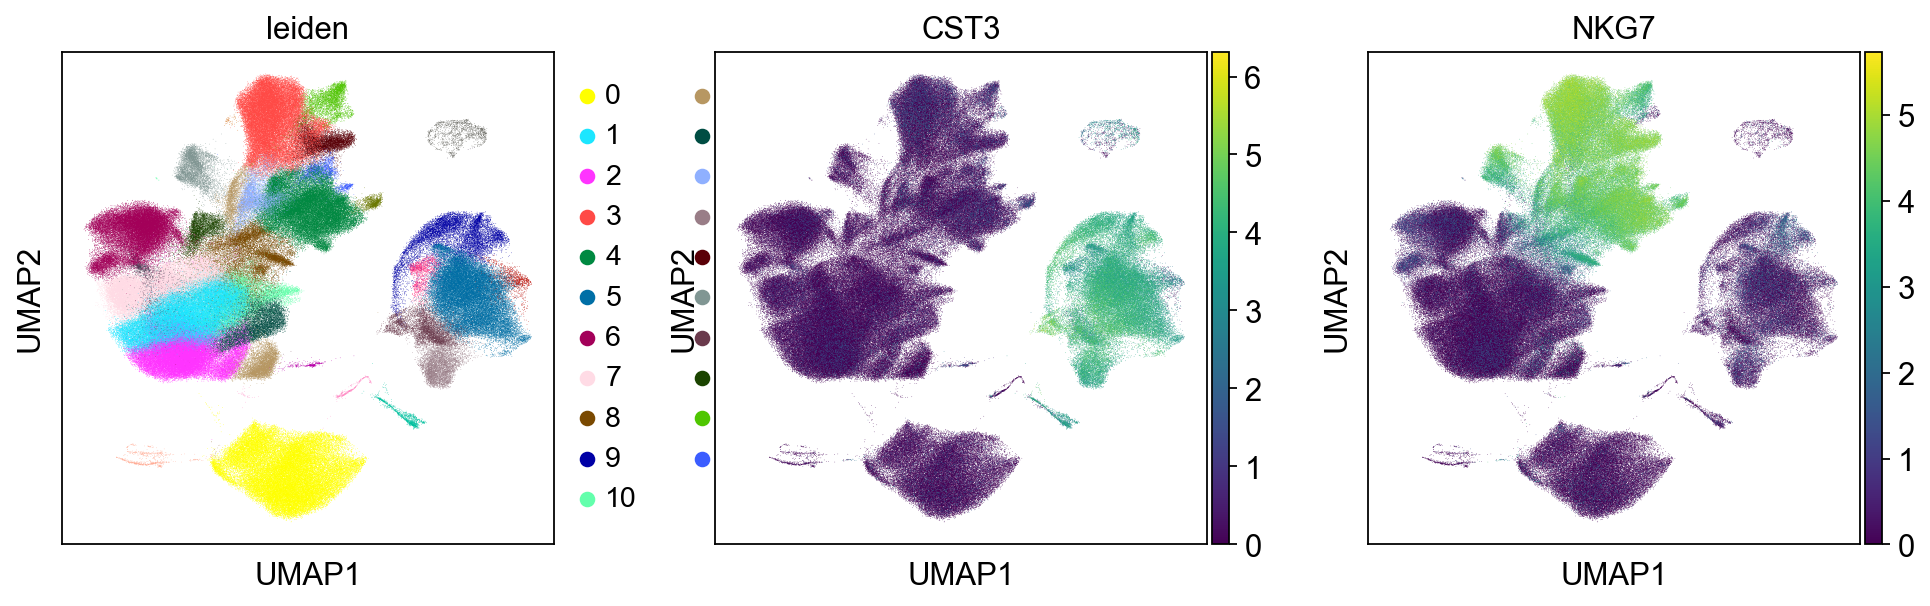

In [40]:
sc.pl.umap(adata2, color=['leiden', 'CST3', 'NKG7'])


In [39]:
adata2.write(results_file)


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'write\pbmc3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


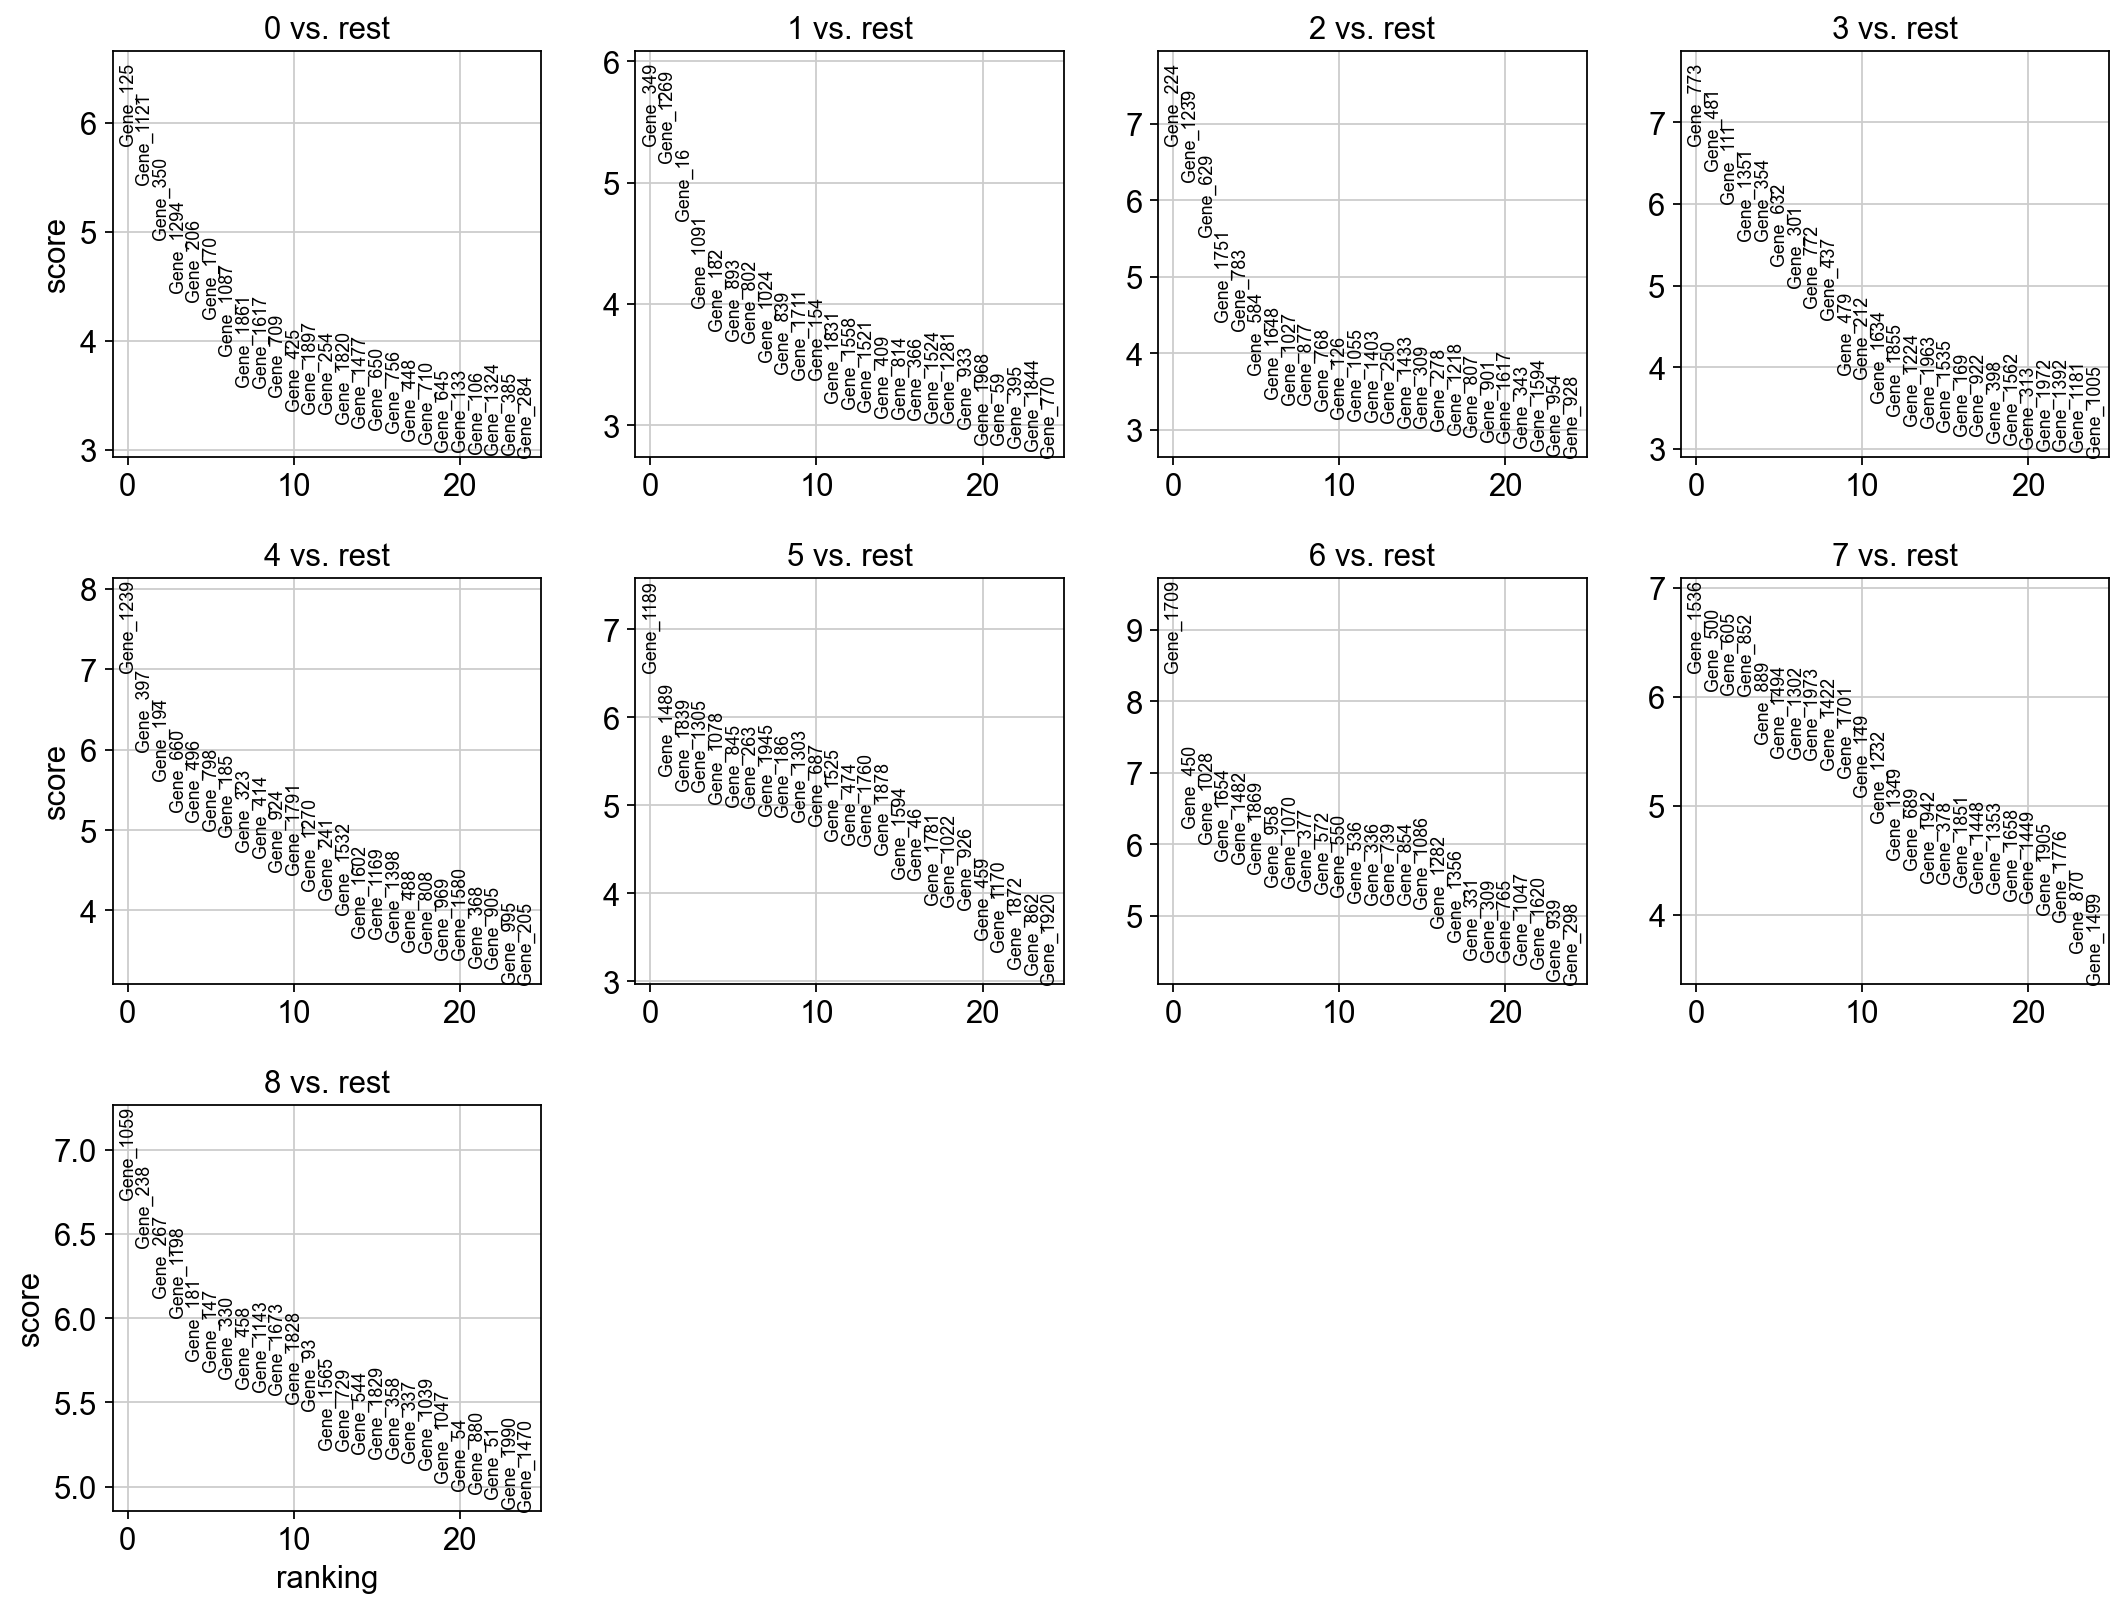

In [40]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)

In [41]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:00)


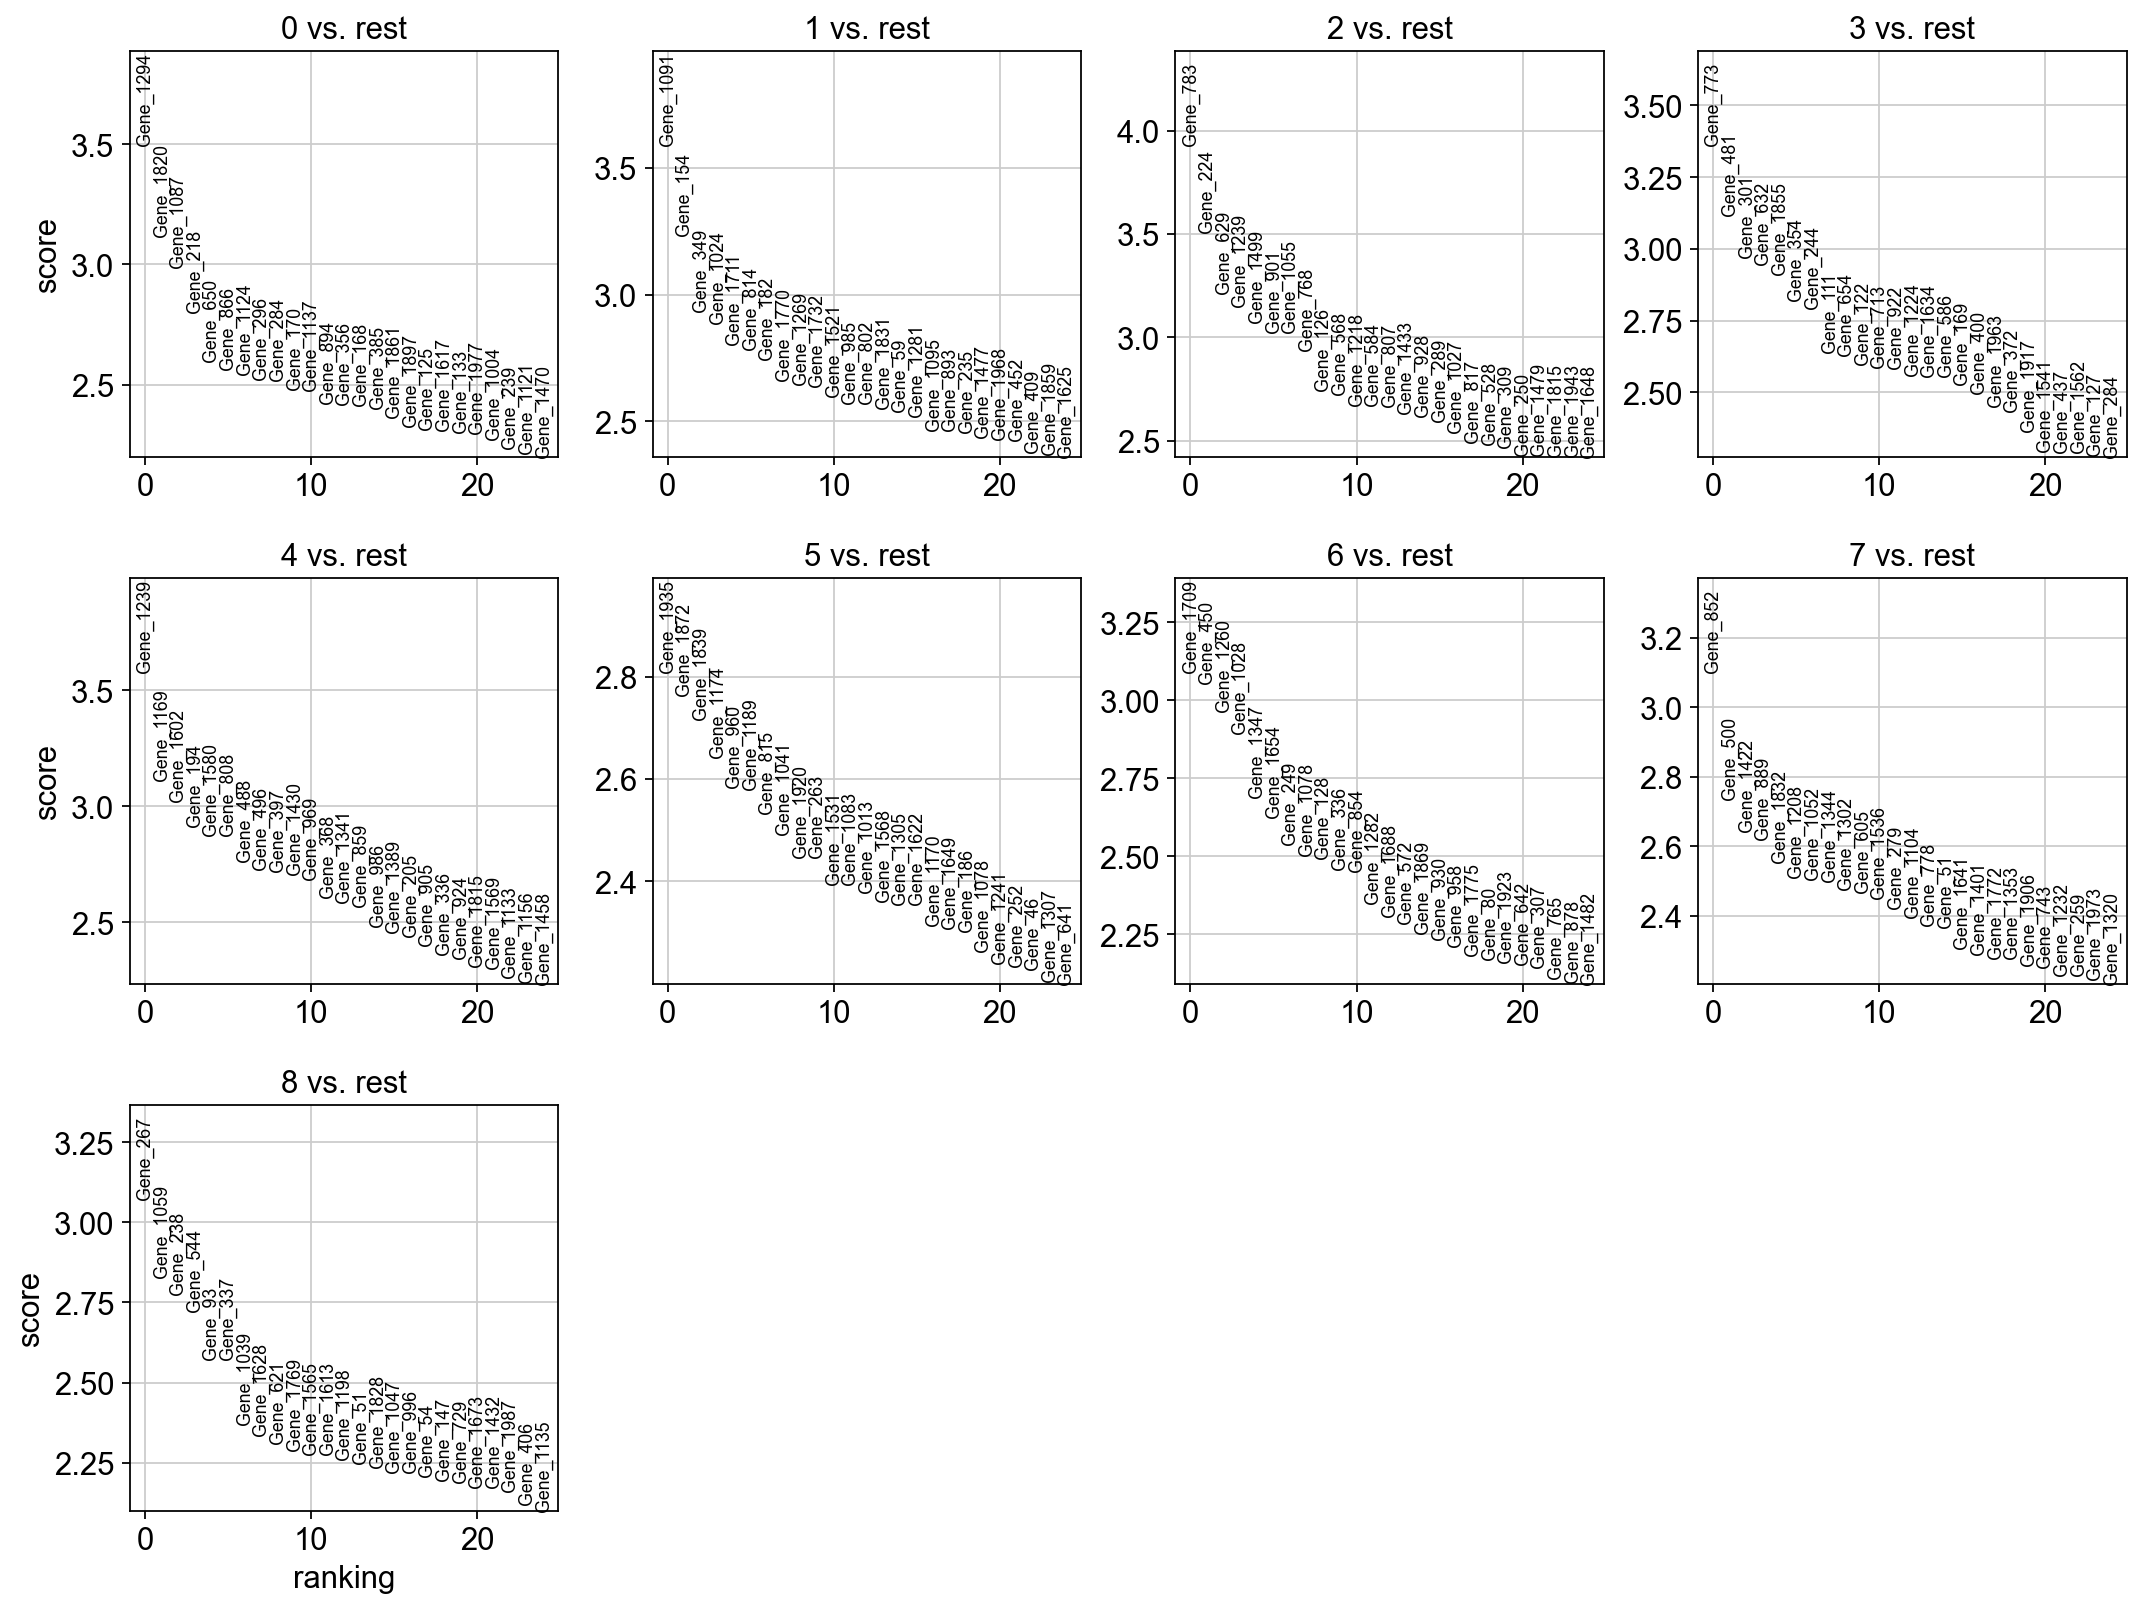

In [42]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)

In [43]:
adata2.write(results_file)

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'write\pbmc3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

ranking genes
    finished (0:00:00)


C:\Users\louis.anderson\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


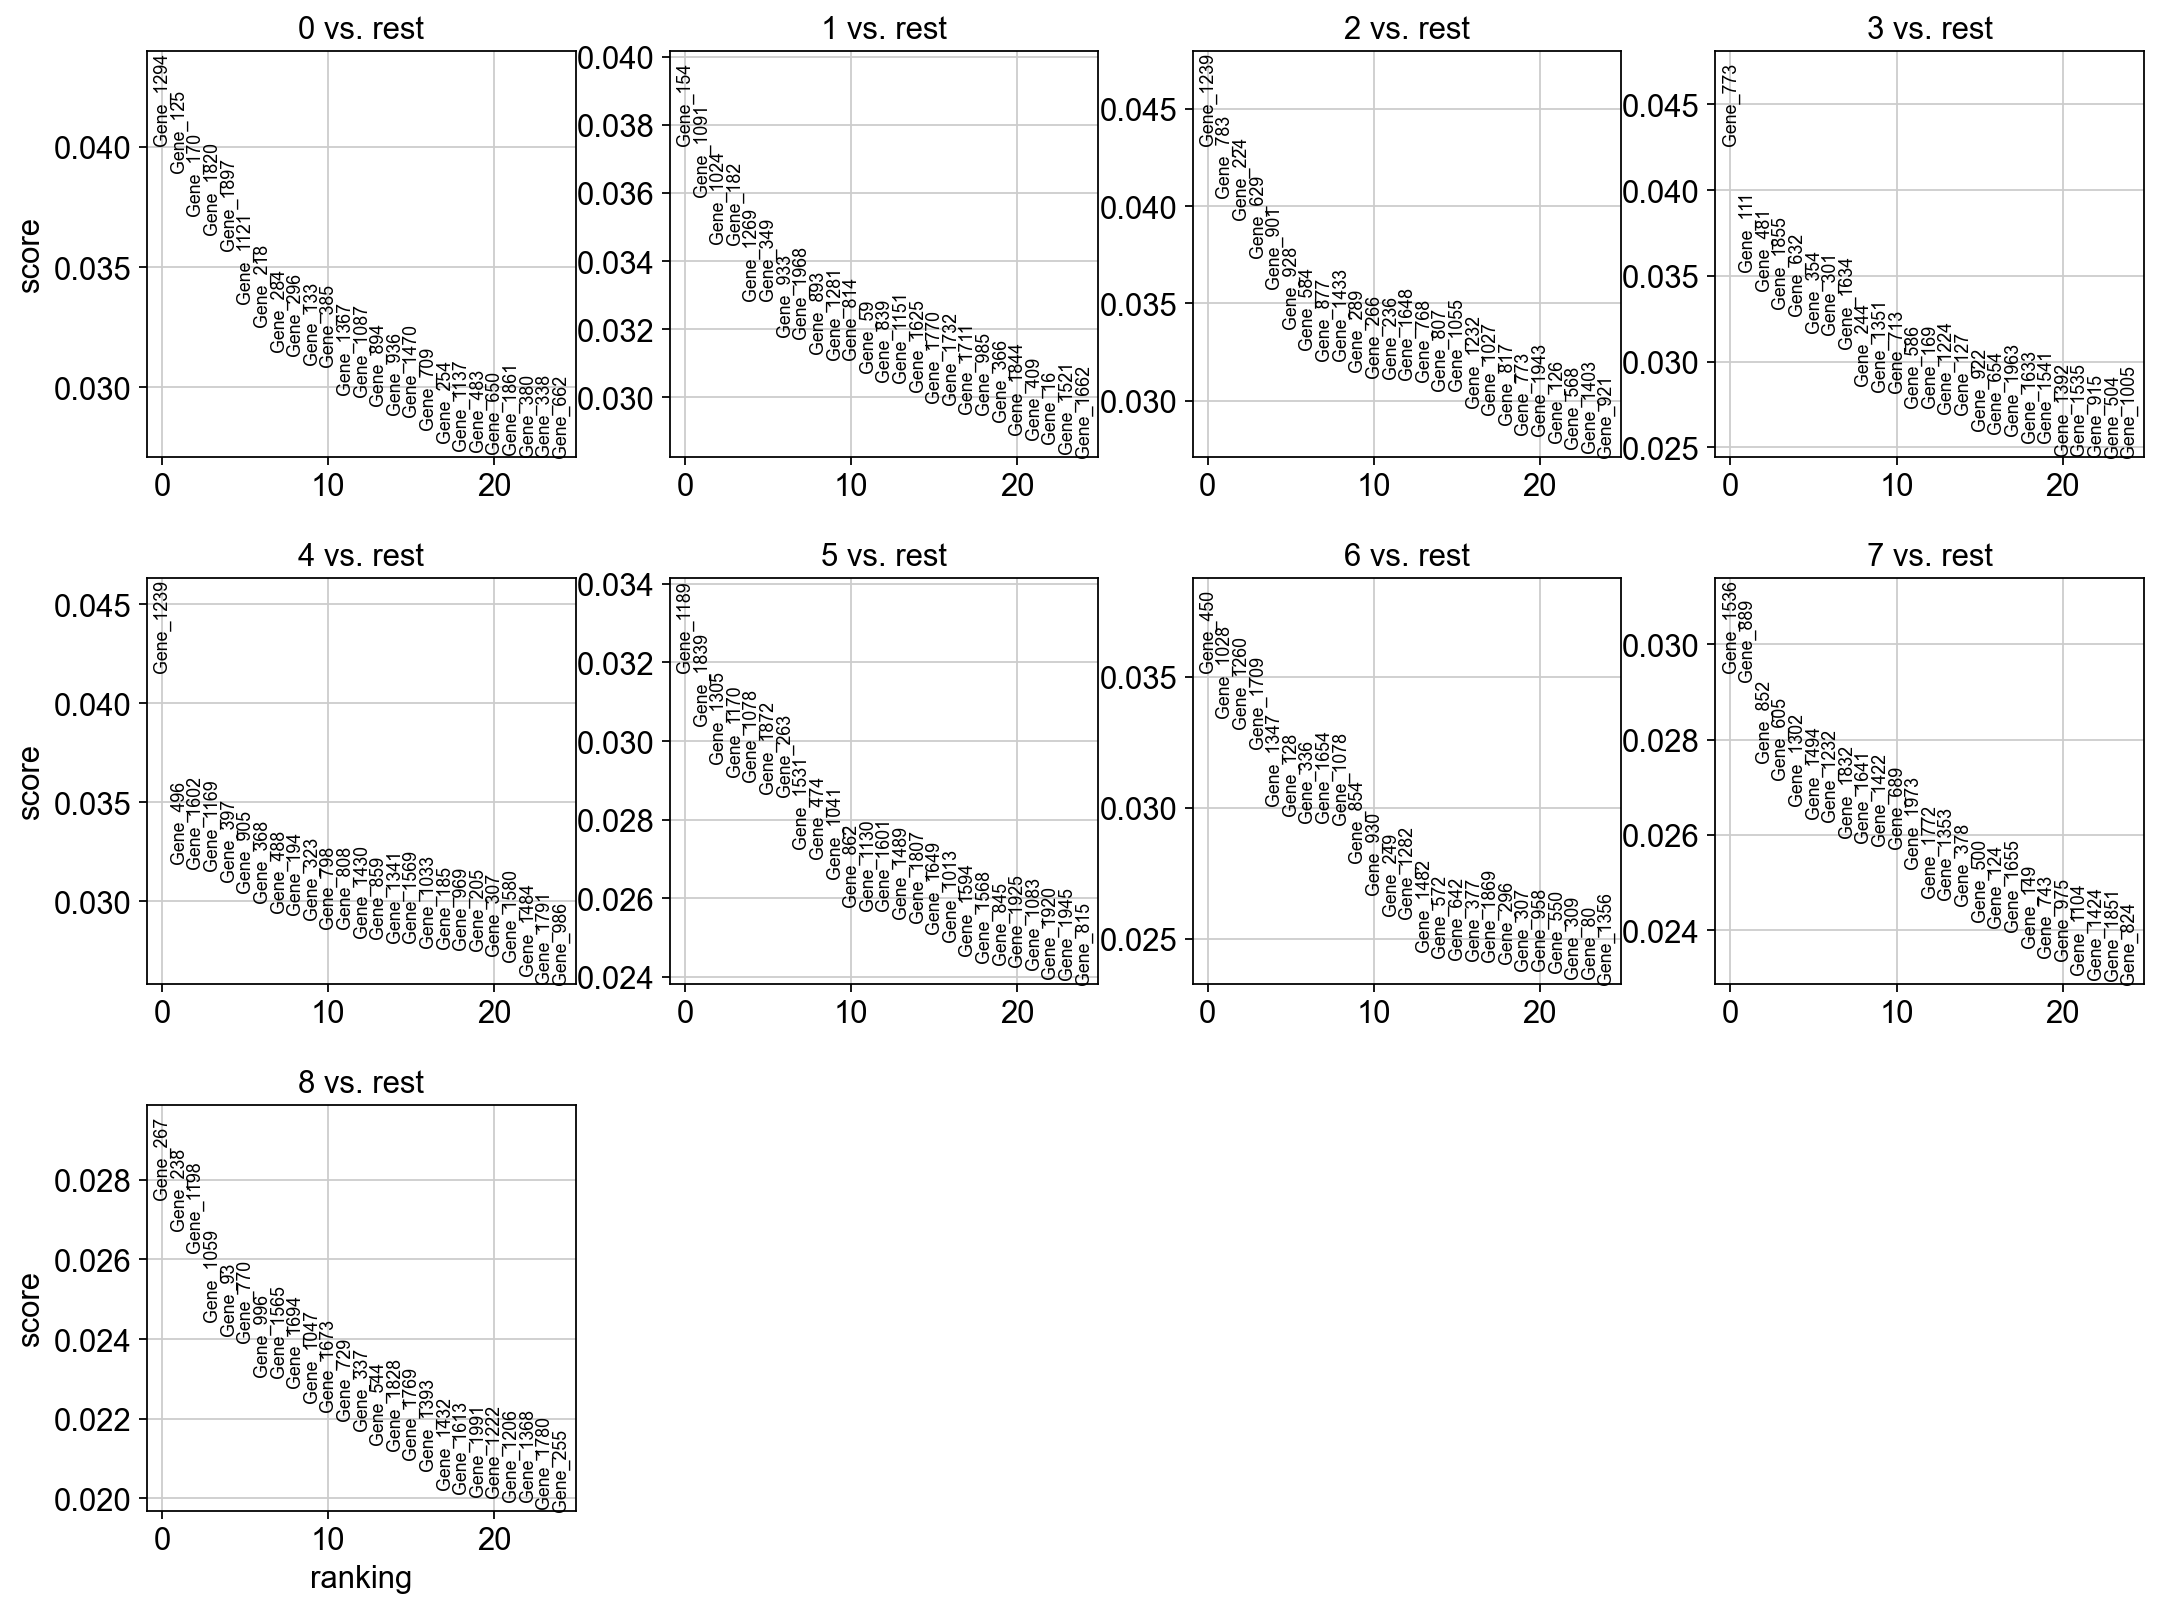

In [44]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)

In [45]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [46]:
adata2 = sc.read(results_file)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'write\pbmc3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [47]:
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(5)

0          1          2          3          4          5  \
0  Gene_1294   Gene_154  Gene_1239   Gene_773  Gene_1239  Gene_1189   
1   Gene_125  Gene_1091   Gene_783   Gene_111   Gene_496  Gene_1839   
2   Gene_170  Gene_1024   Gene_224   Gene_481  Gene_1602  Gene_1305   
3  Gene_1820   Gene_182   Gene_629  Gene_1855  Gene_1169  Gene_1170   
4  Gene_1897  Gene_1269   Gene_901   Gene_632   Gene_397  Gene_1078   

           6          7          8  
0   Gene_450  Gene_1536   Gene_267  
1  Gene_1028   Gene_889   Gene_238  
2  Gene_1260   Gene_852  Gene_1198  
3  Gene_1709   Gene_605  Gene_1059  
4  Gene_1347  Gene_1302    Gene_93

In [48]:
result = adata2.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

KeyError: 'pvals'

ranking genes
    finished (0:00:00)


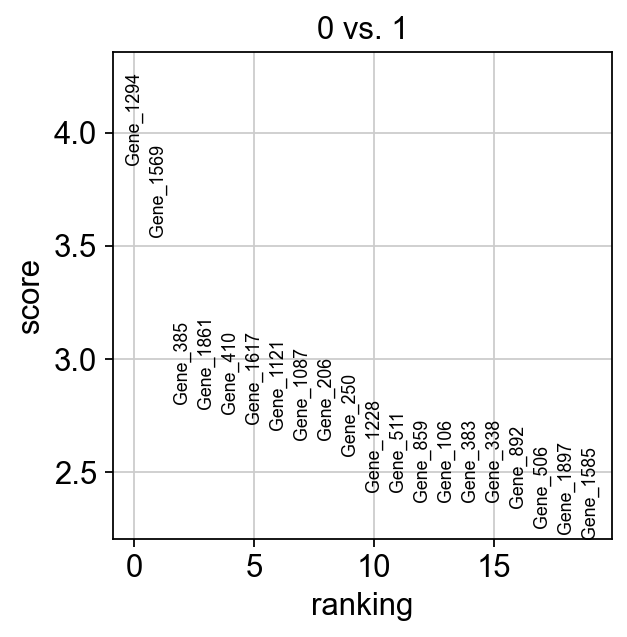

In [49]:
sc.tl.rank_genes_groups(adata2, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata2, groups=['0'], n_genes=20)

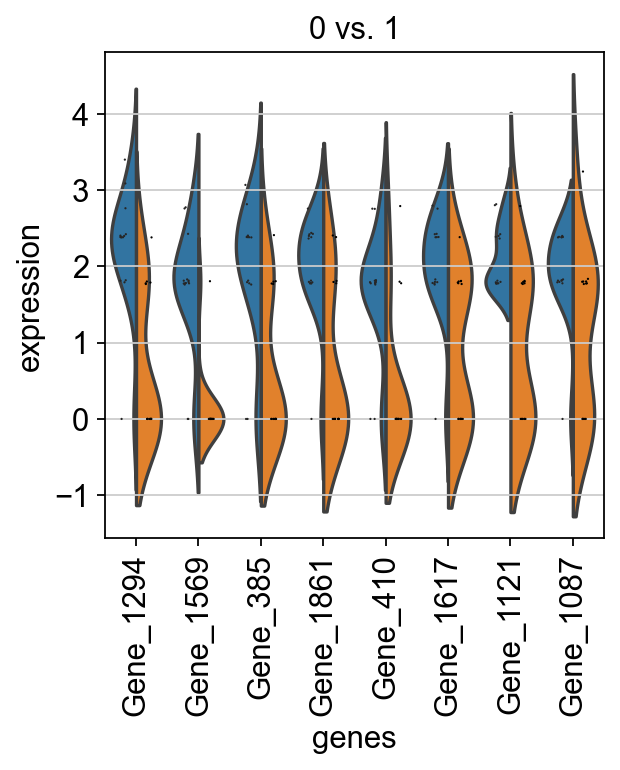

In [50]:
sc.pl.rank_genes_groups_violin(adata2, groups='0', n_genes=8)

In [95]:
adata2 = sc.read(results_file)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'write\pbmc3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [96]:
sc.pl.rank_genes_groups_violin(adata2, groups='0', n_genes=8)

KeyError: 'names'

In [97]:
sc.pl.violin(adata2, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

KeyError: "Could not find keys '['CST3', 'NKG7', 'PPBP', 'leiden']' in columns of `adata.obs` or in adata.raw.var_names."

In [98]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata2.rename_categories('leiden', new_cluster_names)

ValueError: leiden is neither in `.obs` nor in `.var`.

In [99]:
sc.pl.umap(adata2, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

ZeroDivisionError: division by zero

In [100]:
sc.pl.dotplot(adata2, marker_genes, groupby='leiden');


ValueError: groupby has to be a valid observation. Given leiden, is not in observations: ['cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

In [101]:
sc.pl.stacked_violin(adata2, marker_genes, groupby='leiden', rotation=90);


ValueError: groupby has to be a valid observation. Given leiden, is not in observations: ['cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

In [102]:
adata2

AnnData object with n_obs × n_vars = 0 × 0
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'random', 'rank_genes_groups'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

In [103]:
adata2.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'write\pbmc3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [104]:
adata2.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'write\pbmc3k_withoutX.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [105]:
# Export single fields of the annotation of observations
# adata2.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata2.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata2.write_csvs(results_file[:-5], )